# **RAVIR Challenge**         

Axel Romero       
*Deep Learning for Medical Image Analysis*

1. Data      
    1.1. Data augmentation    
2. SegRAVIR Model     
3. Results   

In [9]:
from source.data import RAVIRDataset
from source.segravir import SegRAVIRModel, Loss_Dice_CE_l2

import os
import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torchview import draw_graph
from torchmetrics import Dice, JaccardIndex
from torch.utils.data.sampler import SubsetRandomSampler

In [10]:
BATCH_SIZE = 2
EPOCHS = 100
LR = 1e-3

## **Data**

In order to use the RAVIR dataset we defined a Dataset class called `RAVIRDataset` with the following parameters: 
* `data_root`: path to the images     
* `segmentation_root`: path to the segmentation masks    
* `size`: size of the images     
* `interpolation`: interporlation used if resize is needed    
* `n_labels`: number of different labels in the segmentation masks    



Then, we define a dataloader with the train and test datasets with a batch size of 8.     

In [11]:
train_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=768,
    interpolation="bicubic",
    n_labels=3,
    augmentation=False
)

test_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=768,
    interpolation="bicubic",
    n_labels=3,
    augmentation=False
)

Now, we can analyse the train and test datasets to see the amount of available data. We can see that the amount of data for training is very small, so we have to perform some data augmentation technique to increse the data. 

In [12]:
print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))

Number of training samples:  23
Number of testing samples:  23


torch.Size([768, 768, 3])
tensor(0.) tensor(1.)
torch.Size([768, 768, 1])
tensor(0, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


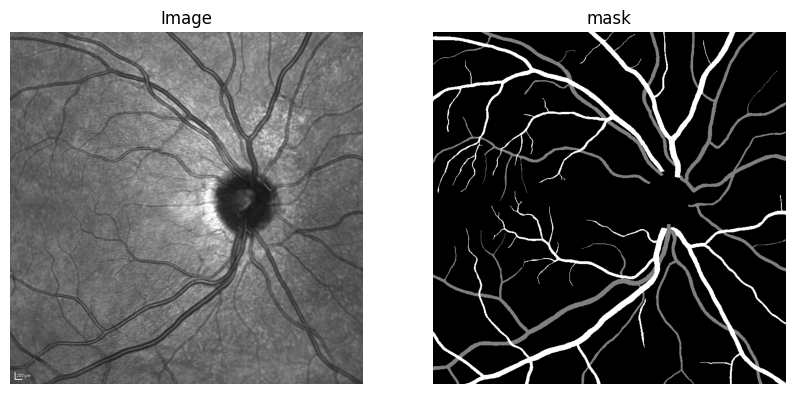

In [13]:
ex = train_data[0]
print(ex['image'].shape)
print(ex['image'].min(), ex['image'].max())
print(ex['mask'].shape)
print(ex['mask'].min(), ex['mask'].max())

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(ex['image'])
axs[0].set_title('Image')
axs[0].axis('off')
axs[1].imshow(ex['mask'], cmap='gray')
axs[1].set_title('mask')
axs[1].axis('off')
plt.show()

### Data Augmentation

For the data augmentation process, we decided to perform, for each image, the following transformations: 
* Horizontal flip    
* Vertical flip     
* Rotation     
* Color jitter    
* Crop    
* Affine transformation    
* Perspective    
* Grayscale      
* Erase      

The implementation of the data augmentation process is in the `data_augmentation.py` script. Now, we can define the dataset with the augmented data and analyze the effect of the different transformations. 

In [14]:
train_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=768,
    interpolation="bicubic",
    n_labels=3,
    augmentation=True
)

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.1 * dataset_size))
np.random.seed(16)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

In [15]:
print("Number of training samples: ", len(train_dataloader)*BATCH_SIZE)
print("Number of validation samples: ", len(val_dataloader)*BATCH_SIZE)
print("Number of testing samples: ", len(test_data))

Number of training samples:  22
Number of validation samples:  2
Number of testing samples:  23


torch.Size([2, 768, 768, 3])
tensor(0.) tensor(1.)
torch.Size([2, 768, 768, 1])
tensor(0, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


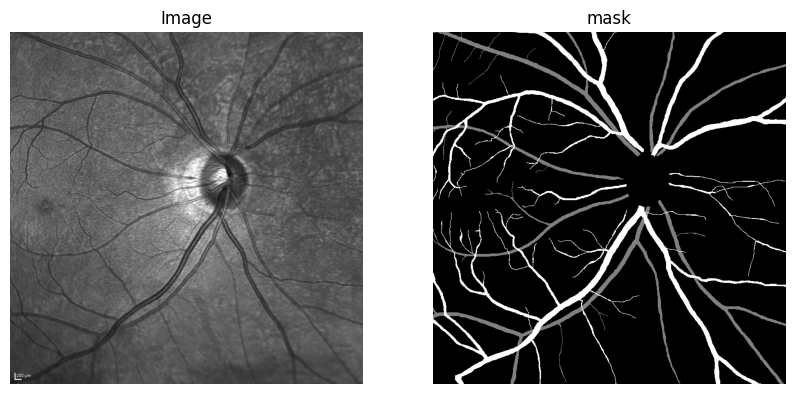

In [16]:
ex = next(iter(train_dataloader))
image = ex['image'].numpy()
mask = ex['mask'].numpy()

print(ex['image'].shape)
print(ex['image'].min(), ex['image'].max())
print(ex['mask'].shape)
print(ex['mask'].min(), ex['mask'].max())

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image[0, ...])
axs[0].set_title('Image')
axs[0].axis('off')
axs[1].imshow(mask[0, ...], cmap='gray')
axs[1].set_title('mask')
axs[1].axis('off')
plt.show()

In [17]:
print("Images shape: ", ex['image'].shape)
print("Masks shape: ", ex['mask'].shape)

Images shape:  torch.Size([2, 768, 768, 3])
Masks shape:  torch.Size([2, 768, 768, 1])


## **SegRAVIR Model**

In [18]:
model = SegRAVIRModel()

print(model)

SegRAVIRModel(
  (encoder): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (residual_layer): Identity()
    )
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ResidualBlock(
      (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(32, eps=1e-

In [19]:
model_graph = draw_graph(model, input_size=(1,3,768,768), expand_nested=False)
model_graph.visual_graph.render('materials/SegRAVIR_graph', view=False)

'materials/SegRAVIR_graph.pdf'

In [20]:
print(summary(model, (3, 768, 768)))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 16, 768, 768]        448
|    └─ResidualBlock: 2-2                [-1, 16, 768, 768]        --
|    |    └─Conv2d: 3-1                  [-1, 16, 768, 768]        2,320
|    |    └─BatchNorm2d: 3-2             [-1, 16, 768, 768]        32
|    |    └─Dropout: 3-3                 [-1, 16, 768, 768]        --
|    |    └─Conv2d: 3-4                  [-1, 16, 768, 768]        2,320
|    |    └─BatchNorm2d: 3-5             [-1, 16, 768, 768]        32
|    |    └─Dropout: 3-6                 [-1, 16, 768, 768]        --
|    |    └─Identity: 3-7                [-1, 16, 768, 768]        --
|    └─Conv2d: 2-3                       [-1, 32, 384, 384]        4,640
|    └─ResidualBlock: 2-4                [-1, 32, 384, 384]        --
|    |    └─Conv2d: 3-8                  [-1, 32, 384, 384]        9,248
| 

In [21]:
loss_dice = smp.losses.DiceLoss(
    mode='multiclass',
    classes=[0, 1, 2]
)
loss_dice = Loss_Dice_CE_l2(
    weight_dice=1.0,
    weight_ce=1.0,
    weight_l2=0.001
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
output_dir = '/media/axelrom16/HDD/AI/RAVIR_Project/model'
os.makedirs(output_dir, exist_ok=True)

wandb.login()

# Initialize wandb
wandb.init(project='SegRAVIR',
           config={
            "batch_size": BATCH_SIZE,
            "learning_rate": LR,
            "dataset": "RAVIR",
        })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: romeroaxel16. Use `wandb login --relogin` to force relogin


In [23]:
wandb.run

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.cuda()
    model.train()
    running_loss = 0.0

    # Initialize tqdm with a dynamic description
    tqdm_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True, dynamic_ncols=True)

    for example in tqdm_iterator:
        image = example['image'].permute(0, 3, 1, 2).cuda()
        mask = example['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda().long()

        # Forward pass
        pred_mask, pred_img = model(image)
        loss = loss_dice(pred_mask, pred_img, mask, image)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Log loss to wandb
        wandb.log({"loss": loss.item(), "learning_rate": optimizer.param_groups[0]["lr"]})

    # Step the learning rate scheduler at the end of each epoch
    lr_scheduler.step()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}') 

    # Validation loop
    if epoch % 10 == 0:
        model.eval()
        for example_val in val_dataloader:
            image = example_val['image'].permute(0, 3, 1, 2).cuda()
            mask = example_val['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda().long()
            pred_mask, pred_img = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)[:, 0, ...]

            # Jaccard Index
            jaccard = JaccardIndex(task="multiclass", num_classes=3, average='macro')
            jaccard_val = jaccard(pred_mask.cpu(), mask.cpu())
            print(f'Jaccard Index: {jaccard_val}')


# Save the trained model if needed
torch.save(model.state_dict(), os.path.join(output_dir, 'trained_model.pth'))

Epoch 1/100: 100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


Epoch [1/100], Loss: 1.8505
Jaccard Index: 0.2910604774951935


Epoch 2/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [2/100], Loss: 1.7086


Epoch 3/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [3/100], Loss: 1.6416


Epoch 4/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [4/100], Loss: 1.5982


Epoch 5/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [5/100], Loss: 1.5533


Epoch 6/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [6/100], Loss: 1.5217


Epoch 7/100: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Epoch [7/100], Loss: 1.4859


Epoch 8/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [8/100], Loss: 1.4545


Epoch 9/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [9/100], Loss: 1.4325


Epoch 10/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [10/100], Loss: 1.4094


Epoch 11/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [11/100], Loss: 1.3972
Jaccard Index: 0.42989933490753174


Epoch 12/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [12/100], Loss: 1.3797


Epoch 13/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [13/100], Loss: 1.3725


Epoch 14/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [14/100], Loss: 1.3761


Epoch 15/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [15/100], Loss: 1.3480


Epoch 16/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [16/100], Loss: 1.3408


Epoch 17/100: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


Epoch [17/100], Loss: 1.3276


Epoch 18/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [18/100], Loss: 1.3291


Epoch 19/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [19/100], Loss: 1.3276


Epoch 20/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [20/100], Loss: 1.3090


Epoch 21/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [21/100], Loss: 1.3017
Jaccard Index: 0.4934595823287964


Epoch 22/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [22/100], Loss: 1.3116


Epoch 23/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [23/100], Loss: 1.3002


Epoch 24/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [24/100], Loss: 1.2924


Epoch 25/100: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]


Epoch [25/100], Loss: 1.2872


Epoch 26/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [26/100], Loss: 1.2834


Epoch 27/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [27/100], Loss: 1.2833


Epoch 28/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [28/100], Loss: 1.2960


Epoch 29/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [29/100], Loss: 1.2910


Epoch 30/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [30/100], Loss: 1.2758


Epoch 31/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [31/100], Loss: 1.2904
Jaccard Index: 0.508976936340332


Epoch 32/100: 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]


Epoch [32/100], Loss: 1.2768


Epoch 33/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [33/100], Loss: 1.2738


Epoch 34/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [34/100], Loss: 1.2755


Epoch 35/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [35/100], Loss: 1.2831


Epoch 36/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [36/100], Loss: 1.2848


Epoch 37/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [37/100], Loss: 1.2723


Epoch 38/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [38/100], Loss: 1.2738


Epoch 39/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [39/100], Loss: 1.2720


Epoch 40/100: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


Epoch [40/100], Loss: 1.2669


Epoch 41/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [41/100], Loss: 1.2617
Jaccard Index: 0.5768654346466064


Epoch 42/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [42/100], Loss: 1.2663


Epoch 43/100: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


Epoch [43/100], Loss: 1.2626


Epoch 44/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [44/100], Loss: 1.2569


Epoch 45/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [45/100], Loss: 1.2566


Epoch 46/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [46/100], Loss: 1.2552


Epoch 47/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [47/100], Loss: 1.2483


Epoch 48/100: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]


Epoch [48/100], Loss: 1.2543


Epoch 49/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [49/100], Loss: 1.2622


Epoch 50/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [50/100], Loss: 1.2507


Epoch 51/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [51/100], Loss: 1.2516
Jaccard Index: 0.6158230900764465


Epoch 52/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [52/100], Loss: 1.2481


Epoch 53/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [53/100], Loss: 1.2494


Epoch 54/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [54/100], Loss: 1.2425


Epoch 55/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [55/100], Loss: 1.2399


Epoch 56/100: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


Epoch [56/100], Loss: 1.2465


Epoch 57/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [57/100], Loss: 1.2403


Epoch 58/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [58/100], Loss: 1.2449


Epoch 59/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [59/100], Loss: 1.2466


Epoch 60/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [60/100], Loss: 1.2468


Epoch 61/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [61/100], Loss: 1.2347
Jaccard Index: 0.6251940727233887


Epoch 62/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [62/100], Loss: 1.2385


Epoch 63/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [63/100], Loss: 1.2375


Epoch 64/100: 100%|██████████| 11/11 [00:03<00:00,  3.42it/s]


Epoch [64/100], Loss: 1.2351


Epoch 65/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [65/100], Loss: 1.2306


Epoch 66/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [66/100], Loss: 1.2425


Epoch 67/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [67/100], Loss: 1.2410


Epoch 68/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [68/100], Loss: 1.2459


Epoch 69/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [69/100], Loss: 1.2414


Epoch 70/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [70/100], Loss: 1.2431


Epoch 71/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [71/100], Loss: 1.2355
Jaccard Index: 0.6185911893844604


Epoch 72/100: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


Epoch [72/100], Loss: 1.2393


Epoch 73/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [73/100], Loss: 1.2342


Epoch 74/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [74/100], Loss: 1.2388


Epoch 75/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [75/100], Loss: 1.2390


Epoch 76/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [76/100], Loss: 1.2354


Epoch 77/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [77/100], Loss: 1.2288


Epoch 78/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [78/100], Loss: 1.2328


Epoch 79/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [79/100], Loss: 1.2292


Epoch 80/100: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]


Epoch [80/100], Loss: 1.2280


Epoch 81/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [81/100], Loss: 1.2379
Jaccard Index: 0.612463653087616


Epoch 82/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [82/100], Loss: 1.2418


Epoch 83/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [83/100], Loss: 1.2281


Epoch 84/100: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [84/100], Loss: 1.2258


Epoch 85/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [85/100], Loss: 1.2312


Epoch 86/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [86/100], Loss: 1.2301


Epoch 87/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [87/100], Loss: 1.2254


Epoch 88/100: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]


Epoch [88/100], Loss: 1.2347


Epoch 89/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [89/100], Loss: 1.2390


Epoch 90/100: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


Epoch [90/100], Loss: 1.2252


Epoch 91/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [91/100], Loss: 1.2321
Jaccard Index: 0.6126968264579773


Epoch 92/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [92/100], Loss: 1.2317


Epoch 93/100: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch [93/100], Loss: 1.2394


Epoch 94/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [94/100], Loss: 1.2352


Epoch 95/100: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch [95/100], Loss: 1.2427


Epoch 96/100: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]


Epoch [96/100], Loss: 1.2256


Epoch 97/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [97/100], Loss: 1.2282


Epoch 98/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [98/100], Loss: 1.2352


Epoch 99/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [99/100], Loss: 1.2286


Epoch 100/100: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]


Epoch [100/100], Loss: 1.2319


torch.Size([2, 1, 768, 768])
tensor(0, device='cuda:0') tensor(2, device='cuda:0')


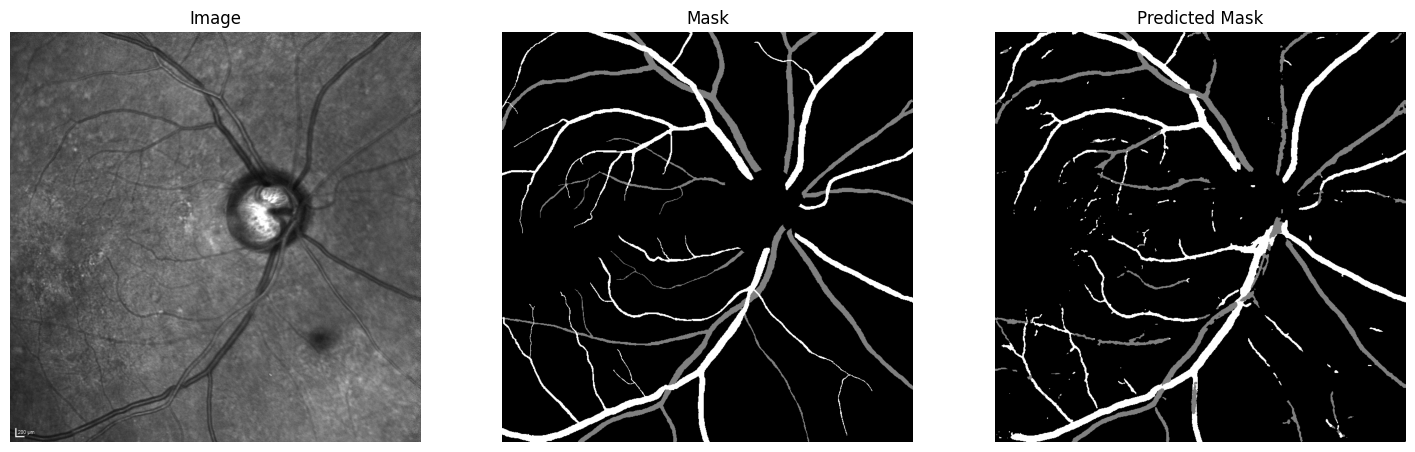

In [28]:
pred_mask, pred_img = model(example_val['image'].permute(0, 3, 1, 2).cuda())
pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
print(pred_mask.shape)
print(pred_mask.min(), pred_mask.max())

fig, axs = plt.subplots(1, 3, figsize=(18, 18))
axs[0].imshow(example_val['image'][0, ...])
axs[0].set_title('Image')
axs[0].axis('off')
axs[1].imshow(example_val['mask'][0, ...], cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')
axs[2].imshow(pred_mask[0, ...].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
axs[2].set_title('Predicted Mask')
axs[2].axis('off')
plt.show()